# Neural Quest Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1DF-OWSP803x34FrvaJ4XeDm_QZUevu32/view?usp=sharing)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
from google.colab import drive
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load *Dataset*
Load data from the given pickle file

In [2]:
# mount Google Drive to access the dataset
drive.mount('/content/drive')

# load the data set
pickle_file_path = '/content/drive/MyDrive/soc/train_data.pkl'
with open(pickle_file_path, 'rb') as f:
    training_data = pickle.load(f)

X = training_data['X']
y = training_data['y']

# normalize
std = np.std(X,axis=0,keepdims=True)
mean=np.mean(X,axis=0,keepdims=True)
X_normalized = (X - mean) / (std + 1e-7)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, stratify=y, random_state=69)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


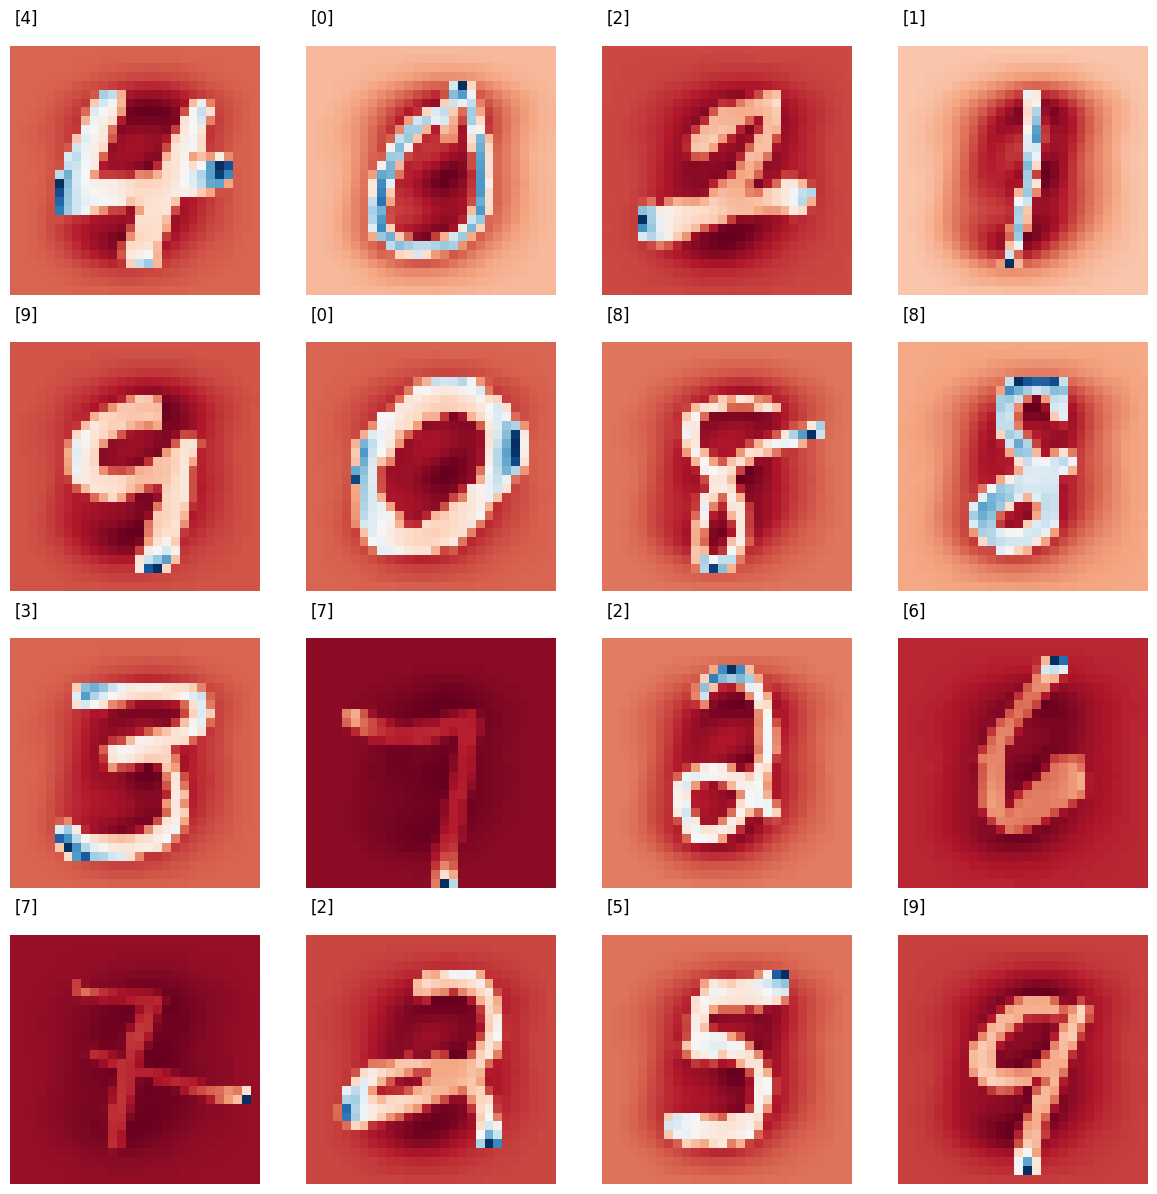

(48000, 784)


In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
num_samples_to_display = 16
random_indices = np.random.choice(len(X_train), num_samples_to_display, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    ax = axes[i]
    images = X_train[idx]
    pixels = images.reshape((28,28))
    ax.imshow(pixels, cmap='RdBu')
    ax.text(0,-3,y_train[idx],fontsize=12)
    ax.axis('off')
plt.tight_layout()
plt.show()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print (X_train.shape)

## Building up parts of our classifier

**Activation functions**

In [4]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    reduced = z - np.max(z,axis=1,keepdims=True)
    e = np.exp(reduced)
    sum = np.sum(e, axis=1, keepdims=True)
    softmax_probs = e / sum
    return softmax_probs

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [5]:
def init_params(n_input, n_hidden, n_output):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    W1 = np.random.randn(n_hidden, n_input) / np.sqrt(n_input ** 2 + n_hidden ** 2)
    b1 = np.zeros((n_hidden, 1))
    W2 = np.random.randn(n_output, n_hidden) / np.sqrt(n_output ** 2 +n_hidden ** 2)
    b2 = np.zeros((n_output, 1))
    return W1, b1, W2, b2

**Forward Propagation**

In [6]:
def forward_propg(X, W1, b1, W2, b2, activation):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    Z1 = np.dot(W1, X.T) + b1.reshape((-1, 1))
    A1 = activation(Z1)
    Z2 = np.dot(W2, A1) + b2.reshape((-1, 1))
    A2 = activation(Z2)
    return A1, Z1, A2, Z2

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [16]:
def backward_propg(X, y, A1, A2, W2):
    """
    should update the weights and return updated weights
    """
    m = y.shape[0]
    dZ2 = A2 - y.T
    dW2 = (1 / m) * np.dot(dZ2, A1.T) 
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1, X) 
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

In [8]:
def cost_func(A2, y):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    m = y.shape[0]
    cost = (1/(2 * m)) * np.sum((A2 - y.T) ** 2)
    return cost


## Integrate everything

In [9]:
def train(X, y, hidden_nodes, epochs, lr):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    W1, b1, W2, b2 = init_params(784, hidden_nodes, 10)

    for i in range(epochs):
        # forward propagation
        A1, Z1, A2, Z2 = forward_propg(X, W1, b1, W2, b2, activation=relu)

        # print cost at every 100 or so iterations
        if i % 100 == 0:
            cost = cost_func(A2, y)
            print ("epoch", i, "=", cost)
        
        # backward propagation
        dW1, db1, dW2, db2 = backward_propg(X, y, A1, A2, W2)
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    updated_weights = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
    return updated_weights

In [10]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    W1 = updated_weights ["W1"]
    b1 = updated_weights ["b1"]
    W2 = updated_weights ["W2"]
    b2 = updated_weights ["b2"]
    A1, Z1, A2, Z2 = forward_propg(X, W1, b1, W2, b2, activation=relu)
    probability = softmax (Z2)
    predictions = np.argmax(probability, axis=0)
    return predictions

In [14]:
def accuracy(predictions, y_test):
    """
    prints % accuracy
    """
    num_correct = np.sum(predictions == y_test)
    acc = (num_correct / y_test.shape[1]) * 100
    return acc

In [17]:
T = train (X_train, y_train, 32, 1000, 1e-5)

epoch 0 = 140.7847563039956


<ipython-input-16-6b7b64410a8a>:10: RuntimeWarning: invalid value encountered in multiply
  dZ1 = np.multiply(dA1, np.int64(A1 > 0))


KeyboardInterrupt: ignored

In [15]:
P = predict (X_test, T)
print (P)
print (y_test.T)
print ("accuracy =", round(accuracy (P, y_test.T), 2), "%")

[5 2 4 ... 0 9 4]
[[5 1 3 ... 2 9 3]]
accuracy = 11.86 %


### Save as pickle

In [ ]:
import pickle
import random
from google.colab import files

roll_num = "22B1236" # enter ldap
hidden_dim = 89 # replace with your own hidden dimension


model_dict = {
    'z': 89, # hidden dimension of your model
    'layer_0_wt': W1,
    'layer_0_bias': b1,
    'layer_1_wt': W2,
    'layer_1_bias': b2
}

assert model_dict['layer_0_wt'].shape == (hidden_dim, 784)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (10, hidden_dim)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

NameError: ignored